# Исследование закономерностей, определяющих успешность игры 
Нужно провести исследование, позволяющее выявить определяющие успешность игры закономерности. Это позволит в дальнейшем 
сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation).
Данные представлены до 2016 года (включительно). Нужно отработать принцип работы с данными, чтобы его можно было использовать в дальнейшем (например, в 2026 году).

В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

## Открытие файла с данными и изучение общей информации

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from scipy import stats as st
import numpy as np


In [2]:
data = pd.read_csv('/datasets/games.csv')
data.info()

print(data.head(10))

data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB
                        Name Platform  Year_of_Release         Genre  \
0                 Wii Sports      Wii           2006.0        Sports   
1          Super Mario Bros.      NES           1985.0      Platform   
2             Mario Kart 

,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


###  Общий вывод по первому этапу исследования

Датафрейм состоит из 11 столбов и 16715 строк.

Каждая строка - информация об одной игре, содержит следующий перечень информации: название игры, платформа, год издания, жанр, информация по продажам с разбивкой на регионы, экспертные оценки и оценки пользователей.

Перед работой с датафреймом, нужно подготовить исходные данные там, где это возможно и целесообразно для дальнейшего анализа. Первое, что бросается в глаза:

- Имеются столбцы с пропусками (например, Critic_Score - 8578 пропуска);
- Есть игры, которые продавались огромным количеством копий, например свыше 41 млн в Сев. Америке, когда медианное значение по региону лишь чуть свыше 260 тыс. копий;
- Некоторые столбцы нуждаются в корректировке типа, например Year_of_Release (год издания) из типа float в тип int.

## Подготовка данных

In [3]:
print('Количество явных дубликатов:', data.duplicated().sum())
data.columns = data.columns.str.lower()

# Удаление строк с пропусками в столбцах: названия игры, года издания, платформы
data = data.dropna(subset=['name']).reset_index(drop=True)
data = data.dropna(subset=['year_of_release']).reset_index(drop=True)
data = data.dropna(subset=['platform']).reset_index(drop=True)

data['year_of_release'] = data['year_of_release'].astype(int)

Количество явных дубликатов: 0


In [4]:
data['total_sales'] = data[['na_sales','eu_sales','jp_sales', 'other_sales']].sum(axis = 1)

Выше создан столбец с суммарными продажами по каждой игре

In [5]:
data['user_score'].unique()

print(data.query('user_score == "tbd"')['name'].count())
data_m = data.query('user_score == "tbd"')
print(data_m.head(10))

data.loc[:, 'user_score'] = data.loc[:, 'user_score'].replace('tbd', np.nan, regex=True)
data['user_score'] = data['user_score'].astype(float)


2376
                                name platform  year_of_release       genre  \
119                    Zumba Fitness      Wii             2010      Sports   
300   Namco Museum: 50th Anniversary      PS2             2005        Misc   
516                  Zumba Fitness 2      Wii             2011      Sports   
639                     uDraw Studio      Wii             2010        Misc   
709                  Just Dance Kids      Wii             2010        Misc   
716        Dance Dance Revolution X2      PS2             2009  Simulation   
810                  The Incredibles      GBA             2004      Action   
870    Who wants to be a millionaire       PC             1999        Misc   
1036                   Tetris Worlds      GBA             2001      Puzzle   
1037                Imagine: Teacher       DS             2008  Simulation   

      na_sales  eu_sales  jp_sales  other_sales  critic_score user_score  \
119       3.45      2.59      0.00         0.66           Na

Выяснилось две причины того, что в столбце 'user_score' тип данных object: наличие значения 'tbd' и то, что рейтинг пользователей представлен в строчном формате.

Заменили tbd на NaN и привели значения в столбце 'user_score' к 'float'

In [6]:
data['rating'] = data['rating'].fillna('TBD')
print(data['rating'].unique())
data.loc[:, 'rating'] = data.loc[:, 'rating'].replace('K-A', 'E', regex=True)

['E' 'TBD' 'M' 'T' 'E10+' 'K-A' 'AO' 'EC' 'RP']


Поиск в интернете подсказал, что в столбец 'rating' есть дубликаты, так как нынешний рейтинг E - это старый рейтинг K-A. Произвели замену неявного дубликата.

NaN заменили на TBD - "подлежит уточнению".

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16444 entries, 0 to 16443
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int64  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       7463 non-null   float64
 10  rating           16444 non-null  object 
 11  total_sales      16444 non-null  float64
dtypes: float64(7), int64(1), object(4)
memory usage: 1.5+ MB


###  Общий вывод по второму этапу исследования:
На данном этапе произвели "первичную" обработку данных:
- Название колонок переведены в нижний регистр;
- Удалены строки с отсутствующими значениями по стобцам 'name', 'platform', 'year_of_release' (около 1,5% от всех строк);
- Добавлен столбец с информацией об общем объёме продаж для каждой игры.
- Изменён тип данных в столбце 'year_of_release' с float на int;
- Изучен столбец с оценкой пользователей: имеются строки со значением 'tbd' (таких строк 2376). Явных причин отсутствию не обнаружено (такие значения есть в различных годах, платформах и жанрах). Вычислить эти значения не представляется возможным, так как данная попытка может исказить данные для дальнейшего анализа. Заменили на NaN;
- Заменён неявный дубликат в столбец 'rating', заменены пропуски на 'TBD'

## Проведение исследовательского анализа данных

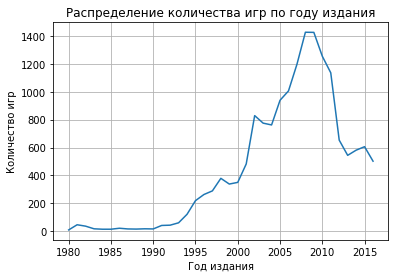

In [9]:
data.groupby(['year_of_release'])['name'].count()
ax = data.groupby(['year_of_release'])['name'].count().plot(grid=True, title='Распределение количества игр по году издания');
ax.set_xlabel('Год издания')
ax.set_ylabel('Количество игр');

На графике можно увидеть, что начиная с середины 1990-х наметился рост количества издаваемых игр, который достиг пика к 2008-2009 годам. Однако последние 7 лет (до 2016) наметилось существенное снижение. 

Сейчас показатель ежегодно издаваемых игр соразмерен цифрам начала нулевых.


Можно предположить, что несмотря на уменьшение количества игр, продажи не падают. Проверим:

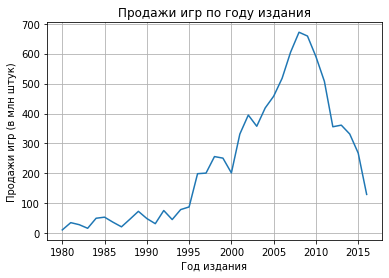

In [10]:
data.groupby(['year_of_release'])['total_sales'].sum()
ax = data.groupby(['year_of_release'])['total_sales'].sum().plot(grid=True, title='Продажи игр по году издания');
ax.set_xlabel('Год издания')
ax.set_ylabel('Продажи игр (в млн штук)');

Продажи тоже упали. 

Возможно, причина в изменении рынка игр в целом: после 2010 года началось развитие Android, мировой финансовый кризис тоже мог изменить "картину" потребления, а также в целом после 2012 года началось развитие подписочных схем и условно-бесплатных игр на ПК, которые могли снизить уровень продаж и сделать консоли более дорогим "удовольствием". Но это всё не утверждения, а аккуратные предположения.

Любопытно, что в 2016 году продажи якобы "рухнули" в более чем 2 раза, хотя игр издавалось на том же уровне. Может просто многие игры только начали издаваться и не "собрали" свою кассу.

In [11]:
# сгруппируем данные по платформам и продажам, выведем топ-10 платформ
data_platform = data.groupby(['platform'], as_index=False, )['total_sales'].sum()\
.sort_values(by='total_sales', ascending=False).reset_index(drop=True)
print(data_platform.head(10))

# Создадим сводную таблицу по топ-10 платформам и ежегодным продажам
data_m = data.loc[data['platform'].isin(data_platform['platform'].head(10))]
data_x = data_m.pivot_table(index='platform', values='total_sales', columns='year_of_release', aggfunc=('count'))
print(data_x)

  platform  total_sales
0      PS2      1233.56
1     X360       961.24
2      PS3       931.34
3      Wii       891.18
4       DS       802.78
5       PS       727.58
6      PS4       314.14
7      GBA       312.88
8      PSP       289.53
9      3DS       257.81
year_of_release  1985  1994  1995   1996   1997   1998   1999   2000   2001  \
platform                                                                      
3DS               NaN   NaN   NaN    NaN    NaN    NaN    NaN    NaN    NaN   
DS                1.0   NaN   NaN    NaN    NaN    NaN    NaN    NaN    NaN   
GBA               NaN   NaN   NaN    NaN    NaN    NaN    NaN    1.0  107.0   
PS                NaN  17.0  99.0  164.0  188.0  248.0  200.0  160.0   91.0   
PS2               NaN   NaN   NaN    NaN    NaN    NaN    NaN   82.0  185.0   
PS3               NaN   NaN   NaN    NaN    NaN    NaN    NaN    NaN    NaN   
PS4               NaN   NaN   NaN    NaN    NaN    NaN    NaN    NaN    NaN   
PSP               NaN   N

Чтобы не смотреть все возможные платформы для нахождения исторических закономерностей, выделим наиболее успешные из них. Критерий успешности - количество проданных игр за всё время.

Можно увидеть в сводной таблице выше, что каждая платформа имеет свой жизненный цикл - платформы появляются, достигают свой пик, потом начинают обратное снижение по продажам игр и "вымирают".

Ниже на тепловой карте отображены эти жизненные циклы:

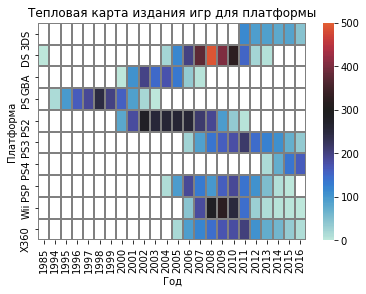

In [12]:
ax = sns.heatmap(data_x, linewidths=1, linecolor='gray', vmin=0, vmax=500, center= 300);
ax.set_title('Тепловая карта издания игр для платформы')
ax.set_xlabel('Год')
ax.set_ylabel('Платформа');

Смущает "вспышка" в 1985 году у Nintendo DS, которая если верить Википедии появилась в 2004. Нужно посмотреть что это за игры такие:

In [13]:
print(data.query('platform == "DS" and year_of_release == 1985'))
data = data.query("name != 'Strongest Tokyo University Shogi DS' or year_of_release != 1985").reset_index(drop=True)

                                      name platform  year_of_release   genre  \
15704  Strongest Tokyo University Shogi DS       DS             1985  Action   

       na_sales  eu_sales  jp_sales  other_sales  critic_score  user_score  \
15704       0.0       0.0      0.02          0.0           NaN         NaN   

      rating  total_sales  
15704    TBD         0.02  


Поиск в интернете по этой игре не принёс результата. Лучше удалить этого "путешественника во времени" из Японии.

### Исследование по определению актуального периода:

In [14]:
# создание столбца продолжительности "жизни" по каждой из топ-10 платформе соответственно
data_x = data_x.fillna(-1).reset_index()
data_x["years_actual"] = data_x.loc[:, 1994:2016].gt(0).sum(axis=1) 

In [15]:
# Ниже блок кода по нахождению средних жизни платформ в зависимости от их статуса на текущий момент
data_x.loc[(data_x[2016] > 0), "actual_status"] = 'yes'
data_x.loc[(data_x[2016] == -1), "actual_status" ] = 'no'
print(data_x[['platform', 'years_actual', 'actual_status']].reset_index(drop=True))

mean_actuality_current_platf = data_x.query('actual_status == "yes"')['years_actual'].mean()
mean_actuality_old_platf = data_x.query('actual_status == "no"')['years_actual'].mean()
mean_actuality_top10 = data_x['years_actual'].mean()

print('Средняя длительность актуальности текущих платформ:', mean_actuality_current_platf \
     ,'\nСредняя длительность актуальности исчезнувших:', mean_actuality_old_platf \
     ,'\nСредняя длительность актуальности всех 10 платформ', mean_actuality_top10 )


year_of_release platform  years_actual actual_status
0                    3DS             6           yes
1                     DS            10            no
2                    GBA             8            no
3                     PS            10            no
4                    PS2            12            no
5                    PS3            11           yes
6                    PS4             4           yes
7                    PSP            12            no
8                    Wii            11           yes
9                   X360            12           yes
Средняя длительность актуальности текущих платформ: 8.8 
Средняя длительность актуальности исчезнувших: 10.4 
Средняя длительность актуальности всех 10 платформ 9.6


По итогу можно сказать, что 10 лет - это средняя продолжительность жизни платформы - от её начала, до "забвения".

In [16]:
data_a = data.loc[data['platform'].isin(data_platform['platform'])]

data_platform = data_a.pivot_table(index='platform', values='total_sales', columns='year_of_release', aggfunc=('count'))

#Создадим столбец со статусом по каждой из 31 платформ (факт продажи игр в 2016 году)
#Но перед этим нужно обработать NaN

data_platform = data_platform.fillna(-1).reset_index()
data_platform["years_actual"] = data_platform.loc[:, 1985:2016].gt(0).sum(axis=1) 
data_platform.loc[(data_platform[2016] > 0), "actual_status"] = 'yes'
data_platform.loc[(data_platform[2016] == -1), "actual_status" ] = 'no'


platform          3DS    PC    PS3    PS4    PSV   Wii  WiiU   X360  XOne
year_of_release                                                          
2012             93.0  61.0  148.0    NaN   53.0  31.0  32.0  106.0   NaN
2013             91.0  38.0  126.0   16.0   63.0  12.0  42.0   75.0  19.0
2014             80.0  47.0  108.0   75.0  100.0   6.0  31.0   63.0  61.0
2015             86.0  50.0   73.0  137.0  110.0   4.0  28.0   35.0  80.0
2016             46.0  54.0   38.0  164.0   85.0   1.0  14.0   13.0  87.0


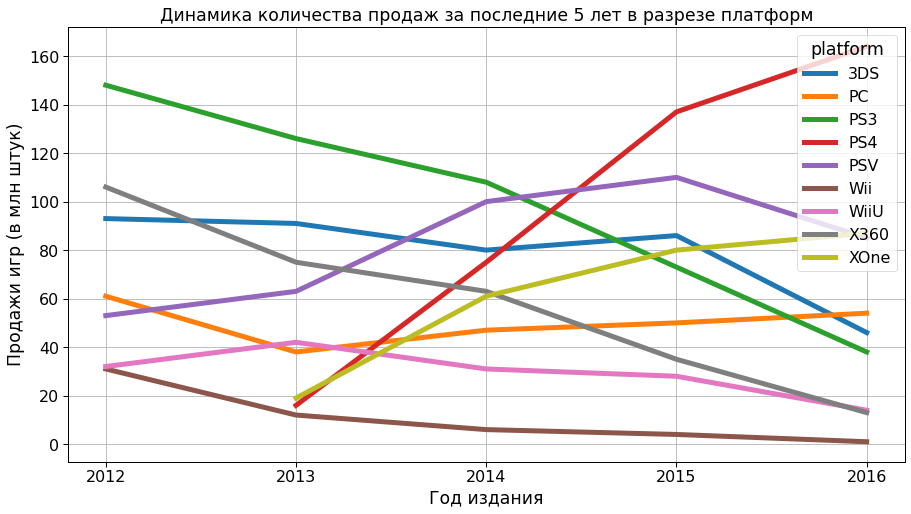

In [17]:
# Добавим в исходный датафрейм столбец с актуальной информацией по платформе
data_for_merge = data_platform[['platform','actual_status']].reset_index(drop=True)
data = data.merge(data_for_merge)

# Осталось создать датафрейм с актуальными данными, применив соответствующее условие
data_act = data.query('actual_status == "yes" and year_of_release > 2011')

# Вывод графика продаж игр по актуальным ("живым") платформам за последние 5 лет
sns.set_context('paper', font_scale=1.8)

data_platforms_now = data_act.pivot_table(index='year_of_release', values='total_sales', columns='platform', \
                                          aggfunc=('count'))
print(data_platforms_now)
ax = data_platforms_now.plot(grid=True, figsize=(15,8), \
      linewidth = 5, title='Динамика количества продаж за последние 5 лет в разрезе платформ');
ax.set_xlabel('Год издания')
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.set_ylabel('Продажи игр (в млн штук)');

Наиболее перспективными выглядят PC, PSV, XOne, PS4.

PC и PSV за счёт объёма продаж - XOne и PS4 за счёт "новизны" и активного роста. При этом PS4 на 2016 год  уже является самой популярной платформой.

count    2682.000000
mean        0.530496
std         1.281546
min         0.010000
25%         0.040000
50%         0.140000
75%         0.470000
max        21.050000
Name: total_sales, dtype: float64


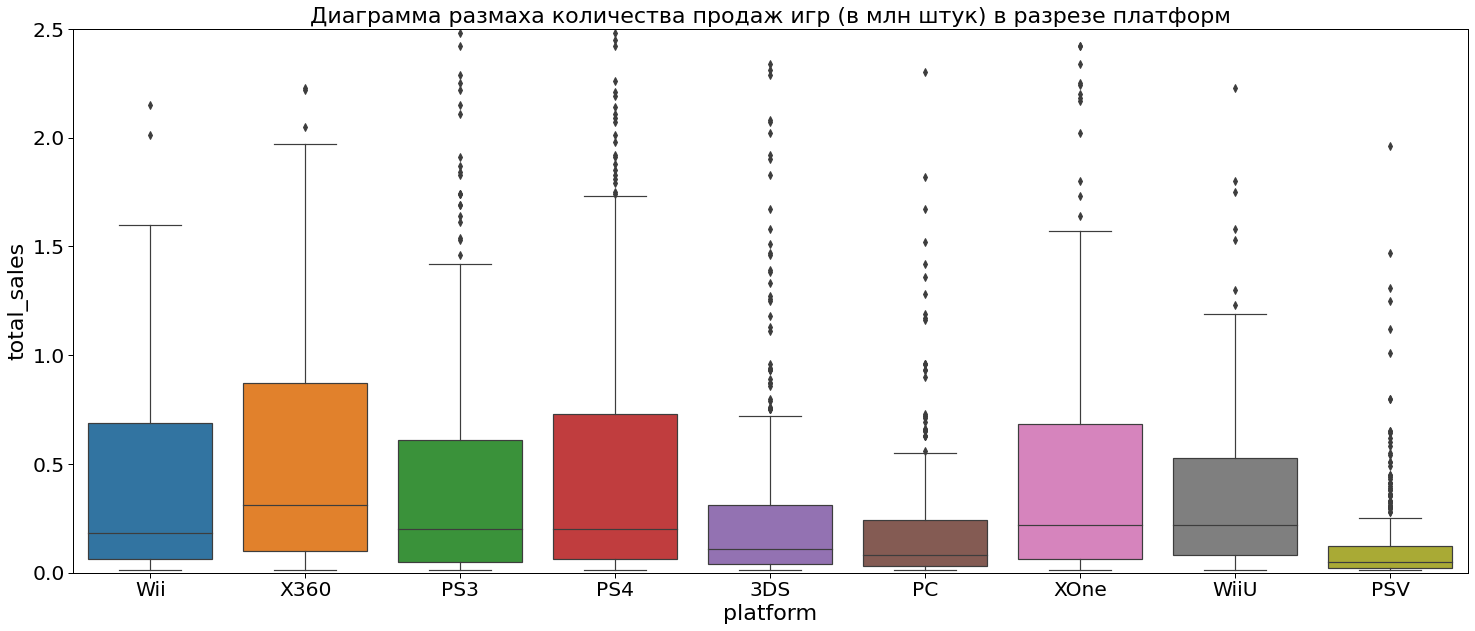

In [18]:
print(data_act['total_sales'].describe())

sns.set_context('paper', font_scale=2.3)
ax = plt.figure(figsize=(25,10))
ax = sns.boxplot(x='platform', y='total_sales', data = data_act)
ax = plt.ylim(0, 2.5)
plt.title("Диаграмма размаха количества продаж игр (в млн штук) в разрезе платформ") 

plt.show();

Подавляющее большинство игр продаются объёмам не более 2 млн копий.

При этом лучше всего продаются игры на на X360, XOne и PS4.

0.3314972592629587


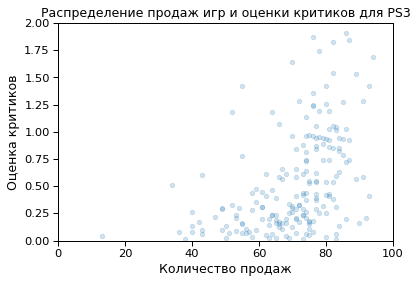

In [19]:
sns.set_context('paper', font_scale=1.3)
ax = data_act[data_act['platform'] == "PS3"].plot(x='critic_score', y='total_sales',\
kind='scatter', alpha=0.2, ylim=(0,2), xlim=(0, 100), title='Распределение продаж игр и оценки критиков для PS3')
ax.set_ylabel('Оценка критиков')
ax.set_xlabel('Количество продаж')
print(data_act[data_act['platform'] == "PS3"]['critic_score'].corr(data_act['total_sales']))

In [20]:
data_for_score = data_act
data_for_score = data_for_score.dropna(subset=['user_score']).reset_index(drop=True)

In [21]:
# функция построения графика распределение продаж игр и оценки критиков для каждой из платформ (+оценка корреляции)
def analyse_platforms_critic(platform):
    ax = data_for_score[data_for_score['platform'] == platform].plot(x='critic_score', y='total_sales', kind='scatter', \
    alpha=0.5, ylim=(0,1.5), xlim=(0, 100), grid=True, title=f'Распределение продаж игр и оценки критиков для {platform}')
    
    ax.set_ylabel('Количество продаж')
    ax.set_xlabel('Оценка критиков')
    corr_critic = data_for_score[data_for_score['platform'] == platform]['critic_score'].corr(data_for_score['total_sales'])
    
    print(f'{platform}: {corr_critic:.2}');

In [22]:
# функция построения графика распределение продаж игр и оценки пользователей для каждой из платформ (+оценка корреляции)
def analyse_platforms_users(platform):
    ax = data_for_score[data_for_score['platform'] == platform].plot(x='user_score', y='total_sales', kind='scatter', \
    alpha=0.5, ylim=(0,2), xlim=(0, 10), grid=True, title=f'Распределение продаж игр и оценки пользователей для {platform}')
    
    ax.set_ylabel('Количество продаж')
    ax.set_xlabel('Оценка пользователей')
    corr_user = data_for_score[data_for_score['platform'] == platform]['user_score'].corr(data_for_score['total_sales'])
    
    print(f'{platform}: {corr_user:.2}')

Корреляция между оценкой пользователей и продажами игр для кажой из платформ:
Wii: -0.42
X360: 0.36
PS3: 0.33
PS4: 0.41
3DS: 0.31
PC: 0.24
XOne: 0.41
WiiU: 0.35
PSV: 0.094


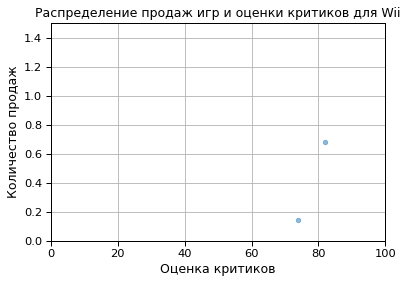

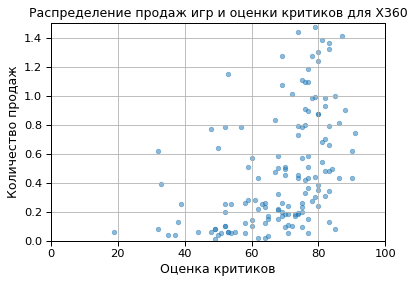

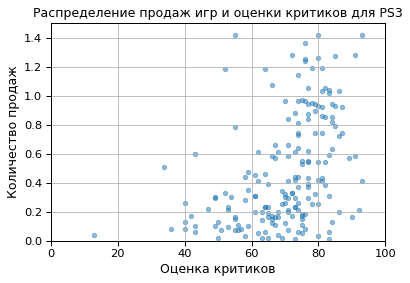

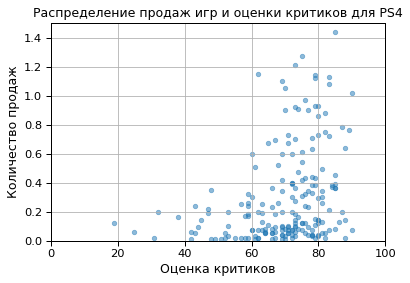

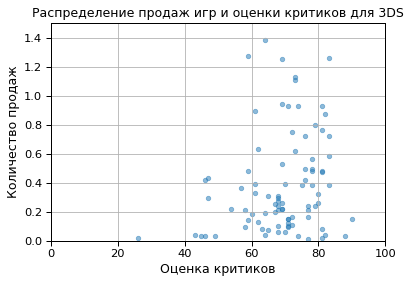

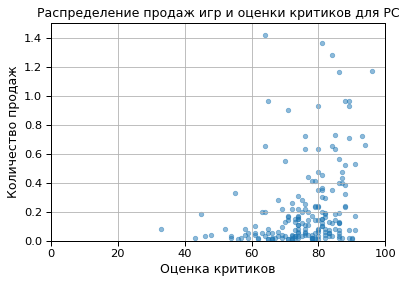

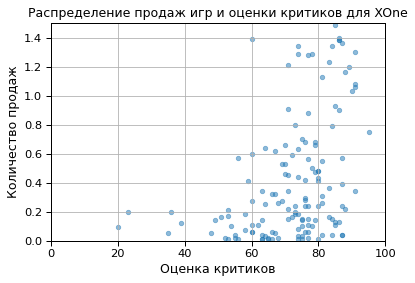

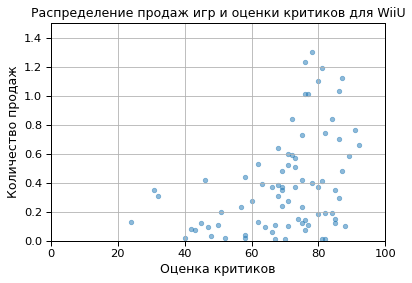

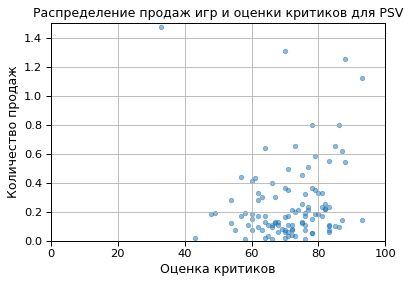

In [23]:
list_platforms = data_for_score['platform'].unique()
print('Корреляция между оценкой пользователей и продажами игр для кажой из платформ:')
for i in list_platforms:
    analyse_platforms_critic(i)

Корреляция между оценкой пользователей и продажами игр для кажой из платформ:
Wii: 0.3
X360: 0.0062
PS3: -0.0051
PS4: -0.032
3DS: 0.2
PC: -0.12
XOne: -0.069
WiiU: 0.4
PSV: -0.0043


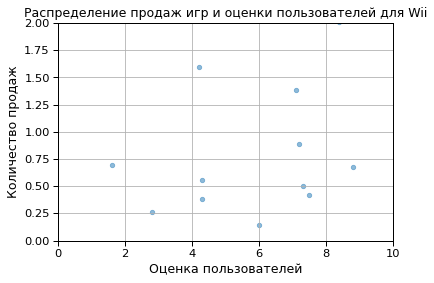

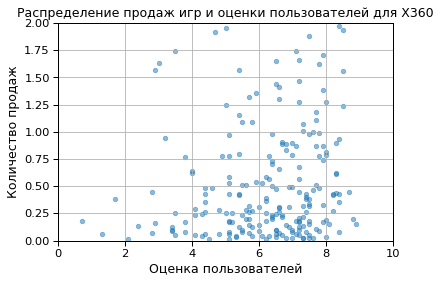

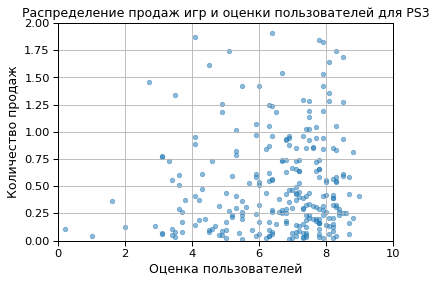

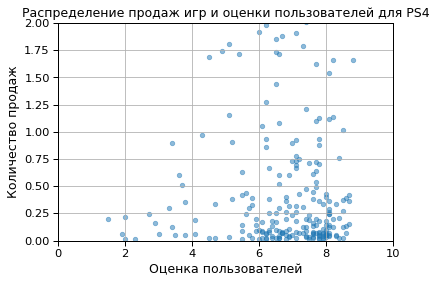

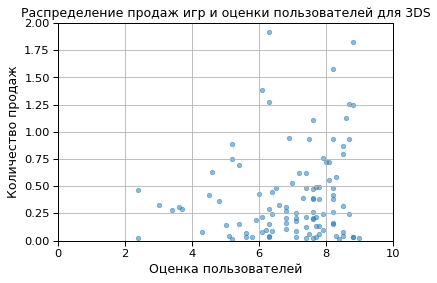

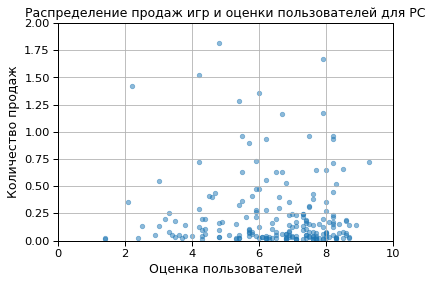

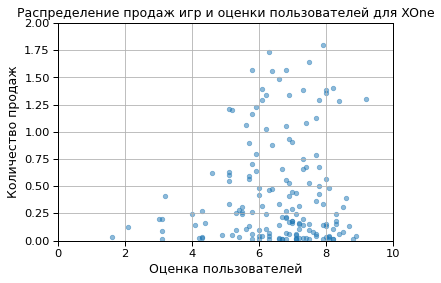

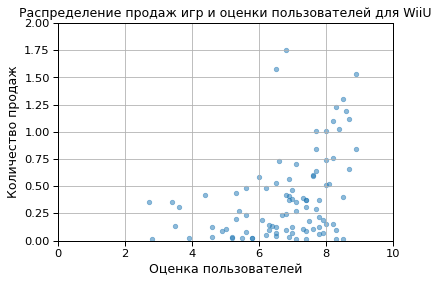

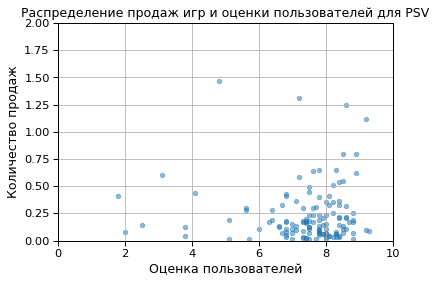

In [24]:
print('Корреляция между оценкой пользователей и продажами игр для кажой из платформ:')
for i in list_platforms:
    analyse_platforms_users(i)

Можно проследить наличие слабой положительной корреляции между оценками экспертов и количеством продаж. Это справедливо для таких платформ как PS4 (0.41), XOne (0.41), X360 (0.36), PS3 (0.33).

Что не сказать про ситуацию с пользовательскими оценками. Здесь можно увидеть корреляцию слабой силы лишь для платформы WiiU (0.4). Для остальных платформ говорить о какой-либо корреляции не представляется возможным.

Отрицательная корреляция у  Wii экспертных оценок и продаж не должна тревожить - данных в выборе недостаточно для того, чтобы сделать однозначные выводы.

In [47]:
len(data_act), len(data.query('year_of_release > 2011'))

(2682, 2886)

           genre     sum  count  median      mean
0         Action  435.54    953   0.130  0.457020
1        Shooter  304.73    235   0.440  1.296723
2   Role-Playing  180.91    339   0.160  0.533658
3         Sports  179.55    256   0.270  0.701367
4           Misc   84.15    180   0.140  0.467500
5       Platform   60.31     83   0.210  0.726627
6         Racing   53.50    115   0.140  0.465217
7       Fighting   44.13    105   0.150  0.420286
8     Simulation   34.85     78   0.120  0.446795
9      Adventure   27.70    247   0.040  0.112146
10      Strategy   12.63     67   0.080  0.188507
11        Puzzle    4.79     24   0.055  0.199583


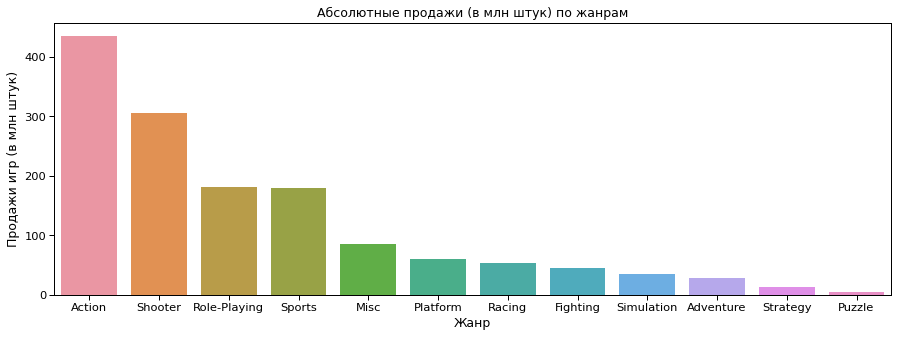

In [25]:
data_genre = data_act.pivot_table(index='genre', values='total_sales', aggfunc= ['sum', 'count', 'median', 'mean'])
data_genre.columns = ['sum', 'count', 'median', 'mean']
data_genre = data_genre.sort_values(by='sum', ascending=False).reset_index()
print(data_genre)

sns.set_context('paper', font_scale=1.3)

plt.figure(figsize=(15,5))
ax = sns.barplot(data=data_genre, x='genre', y='sum')
plt.title("Абсолютные продажи (в млн штук) по жанрам") 
ax.set_xlabel('Жанр')
ax.set_ylabel('Продажи игр (в млн штук)');
plt.show()

Больше всего продаётся в абсолютном выражении игры жанров Action, Shooter, Role-Playing и Sports. Однако нужно посмотреть посмотреть на диаграмму размаха, чтобы сделать выводы о "прибыльности":

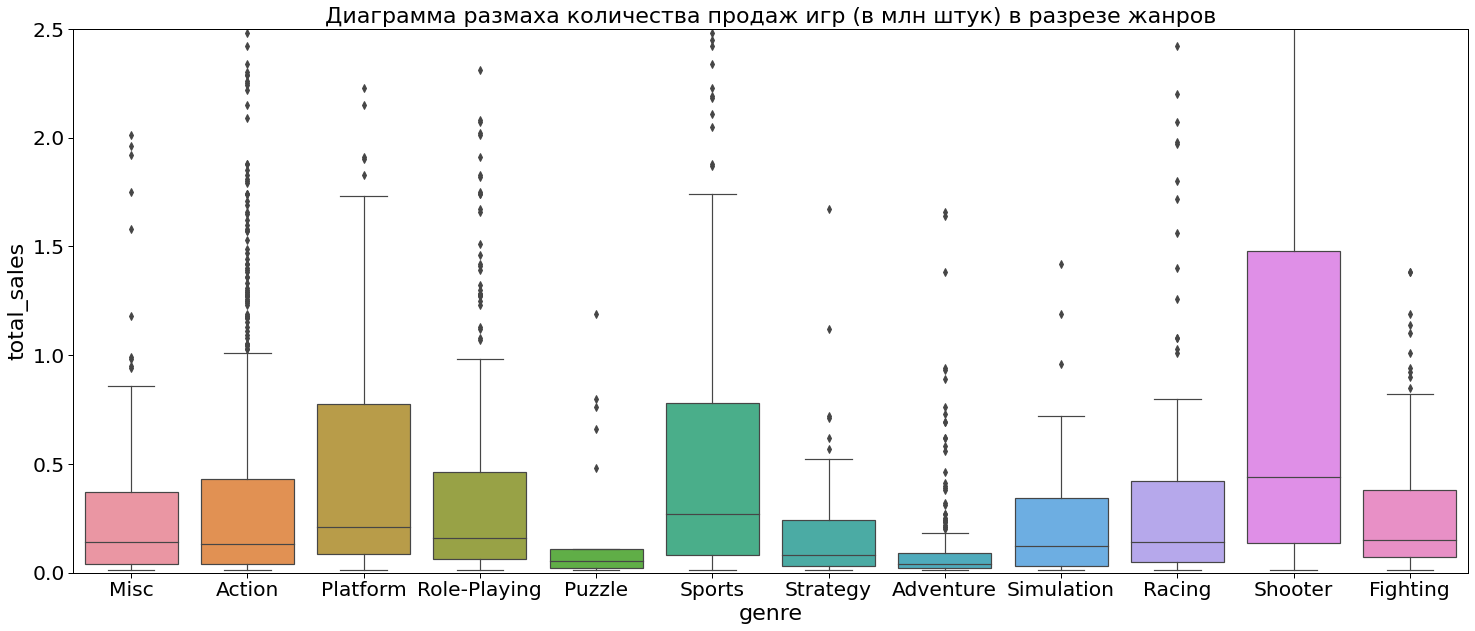

In [26]:
sns.set_context('paper', font_scale=2.3)
ax = plt.figure(figsize=(25,10))
ax = sns.boxplot(x='genre', y='total_sales', data = data_act)
ax = plt.ylim(0, 2.5)
plt.title("Диаграмма размаха количества продаж игр (в млн штук) в разрезе жанров") 

plt.show();

Здесь ситуация несколько иная - Наибольшую "прибыльность" приносят игры жанров Shooter, Sports, Platform. 

Жанр Action не такой "прибыльный", высокие показатели по общим продажам обусловлены "аномальными" продажами по небольшому количеству игр.

###  Общий вывод по третьему этапу исследования:

При исследовании рынка игр удалось обнаружить некоторые закономерности и особенности:


За 30-летнюю историю рынка игр можно выделить два этапа:
1. Бурный рост начиная с 1990-х годов, увеличивший объём "рынка" в 7 раз к 2008 году.
2. Двухкратное падение продаж на рынке с 2009 года по 2015 год (к уровню начала нулевых).

Каждая платформа имеет свой жизненный цикл, отличающийся лишь степенью выраженности того или иного этапа: появление, рост, пик, падение, забвение.

Средняя продолжительность жизни платформы 9 лет. Исключение составляют PC в виду того, что компьютер представляет собой конструктор, который способен адаптироваться к развитию технолологий без необходимости кардинальной смены парадигмы платформы.

На текущий момент (2016 год) наиболее перспективными для игр выглядят следующие платформы PC, PSV, XOne, PS4.
Первые две за счёт объёма продаж - а XOne и PS4 за счёт "новизны" и активного роста. При этом PS4 на 2016 год  уже является самой популярной платформой.

Подавляющее большинство игр продаются объёмам не более 2 млн копий. При этом обнаружилась корреляция слабой силы между оценками экспертов и количеством проданных копий игр. Заметная связь между продажами и оценками пользователей не обнаружена.

Больше всего в абсолютном выражении продавались игры жанров Action, Shooter, Role-Playing и Sports. Однако самым "прибыльным" оказались жанры Shooter, Sports, Platform.

## Составление портрета пользователя каждого региона

  platform     sum  count  median      mean
0     X360  140.05    292    0.17  0.479623
1      PS4  108.74    392    0.06  0.277398
2      PS3  103.38    493    0.05  0.209696
3     XOne   93.12    247    0.12  0.377004
4      3DS   55.31    396    0.00  0.139672


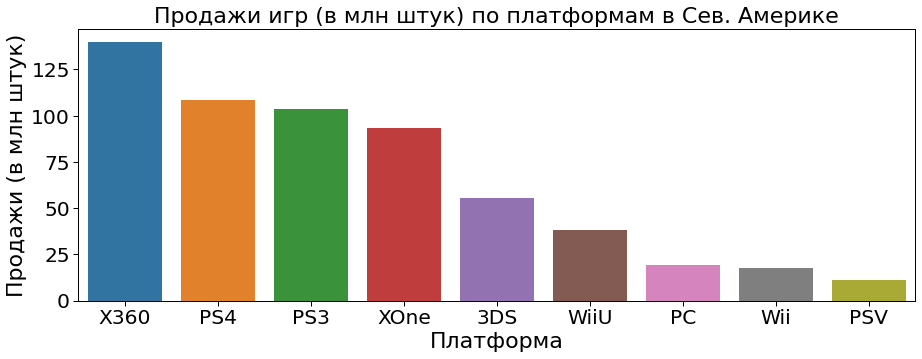

In [27]:
data_platform_na = data_act.pivot_table(index='platform', values='na_sales', aggfunc= ['sum', 'count', 'median', 'mean'])
data_platform_na.columns = ['sum', 'count', 'median', 'mean']
data_platform_na = data_platform_na.sort_values(by='sum', ascending=False).reset_index()
print(data_platform_na.sort_values(by='sum', ascending=False).head(5))

plt.figure(figsize=(15,5))
ax = sns.barplot(data=data_platform_na, x='platform', y='sum')
plt.title("Продажи игр (в млн штук) по платформам в Сев. Америке") 
ax.set_xlabel('Платформа')
ax.set_ylabel('Продажи (в млн штук)');
plt.show()


Наиболее популярная актуальная платформа в Северной Америке за последние 5 лет - X360. Немного позади располагаются PS4, PS3. Набирающая популярность XOne расположилась на четвёртой строчке. Замыкает пятёрку 3DS.

  platform    sum  count  median      mean
0      3DS  87.79    396    0.06  0.221692
1      PS3  35.29    493    0.03  0.071582
2      PSV  21.04    411    0.03  0.051192
3      PS4  15.96    392    0.01  0.040714
4     WiiU  13.01    147    0.00  0.088503


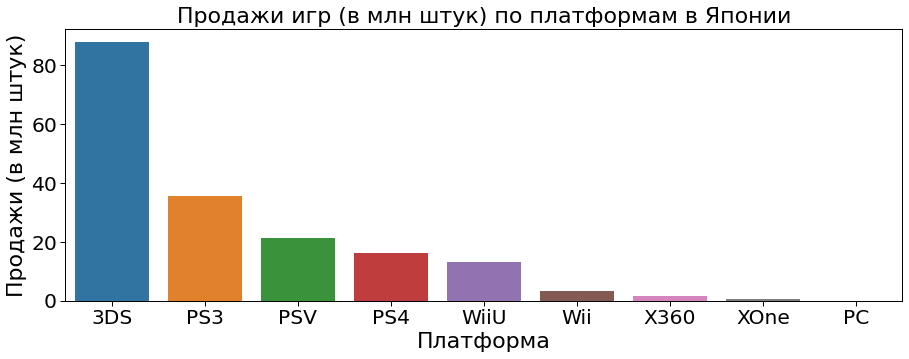

In [28]:
data_platform_jp = data_act.pivot_table(index='platform', values='jp_sales', aggfunc= ['sum', 'count', 'median', 'mean'])
data_platform_jp.columns = ['sum', 'count', 'median', 'mean']
data_platform_jp = data_platform_jp.sort_values(by='sum', ascending=False).reset_index()
print(data_platform_jp.sort_values(by='sum', ascending=False).head(5))

plt.figure(figsize=(15,5))
ax = sns.barplot(data=data_platform_jp, x='platform', y='sum')
plt.title("Продажи игр (в млн штук) по платформам в Японии") 
ax.set_xlabel('Платформа')
ax.set_ylabel('Продажи (в млн штук)');
plt.show()

Наиболее популярная актуальная платформа в Японии за последние 5 лет - 3DS. Существенно позади располагаются PS3, PSV, PS4, WiiU.

  platform     sum  count  median      mean
0      PS4  141.09    392    0.08  0.359923
1      PS3  106.86    493    0.03  0.216755
2     X360   74.52    292    0.10  0.255205
3     XOne   51.59    247    0.07  0.208866
4      3DS   42.64    396    0.00  0.107677


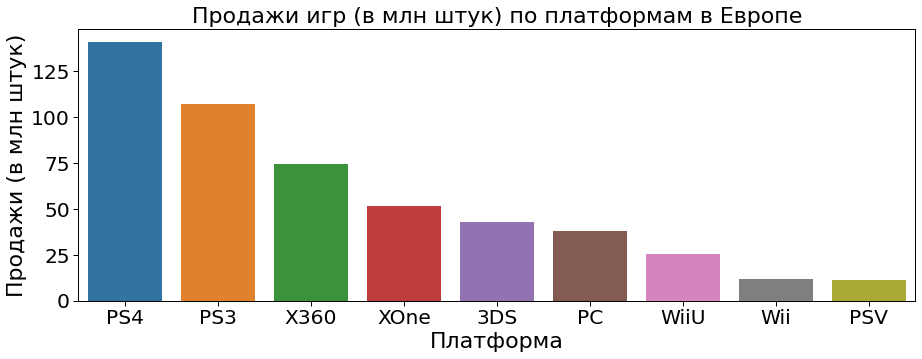

In [29]:
data_platform_eu = data_act.pivot_table(index='platform', values='eu_sales', aggfunc= ['sum', 'count', 'median', 'mean'])
data_platform_eu.columns = ['sum', 'count', 'median', 'mean']
data_platform_eu = data_platform_eu.sort_values(by='sum', ascending=False).reset_index()
print(data_platform_eu.sort_values(by='sum', ascending=False).head(5))

plt.figure(figsize=(15,5))
ax = sns.barplot(data=data_platform_eu, x='platform', y='sum')
plt.title("Продажи игр (в млн штук) по платформам в Европе") 
ax.set_xlabel('Платформа')
ax.set_ylabel('Продажи (в млн штук)');
plt.show()

Наиболее популярная платформа в Европе за последние 5 лет PS4, при этом PS4 - одна из новейших платформ. Следом располагаются PS3, X360. На четвёртом месте новая платформа из Северной Америке XOne.

PS4 на текущий момент демонстрирует высокую "прибыльность". Средняя продажа одной игры - 0,35 млн копий. 

          genre     sum  count  median      mean
0        Action  177.00    953    0.03  0.185729
1       Shooter  144.77    235    0.20  0.616043
2        Sports   81.38    256    0.09  0.317891
3  Role-Playing   60.65    339    0.02  0.178909
4          Misc   38.13    180    0.02  0.211833


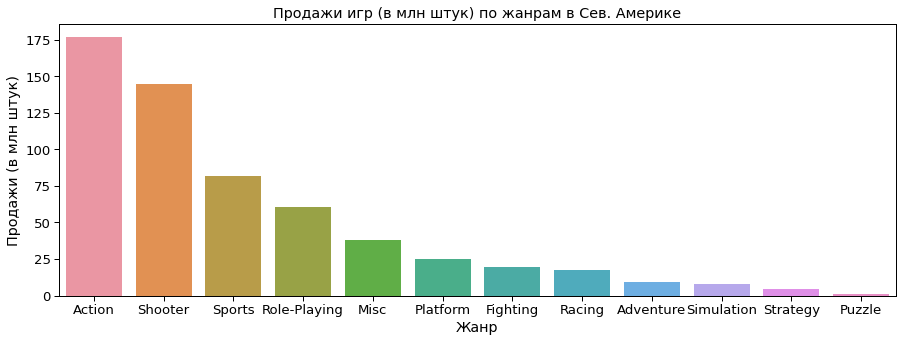

In [30]:
data_genre_na = data_act.pivot_table(index='genre', values='na_sales', aggfunc= ['sum', 'count', 'median', 'mean'])
data_genre_na.columns = ['sum', 'count', 'median', 'mean']
data_genre_na = data_genre_na.sort_values(by='sum', ascending=False).reset_index()
print(data_genre_na.sort_values(by='sum', ascending=False).head(5))

sns.set_context('paper', font_scale=1.5)
plt.figure(figsize=(15,5))
ax = sns.barplot(data=data_genre_na, x='genre', y='sum')
plt.title("Продажи игр (в млн штук) по жанрам в Сев. Америке") 
ax.set_xlabel('Жанр')
ax.set_ylabel('Продажи (в млн штук)');
plt.show()

В Северной Америке самые популярные жанры - Action, Shooter и Sports и Role-Playing.

          genre     sum  count  median      mean
0        Action  158.43    953   0.030  0.166243
1       Shooter  113.47    235   0.170  0.482851
2        Sports   68.84    256   0.055  0.268906
3  Role-Playing   46.76    339   0.010  0.137935
4        Racing   27.29    115   0.090  0.237304


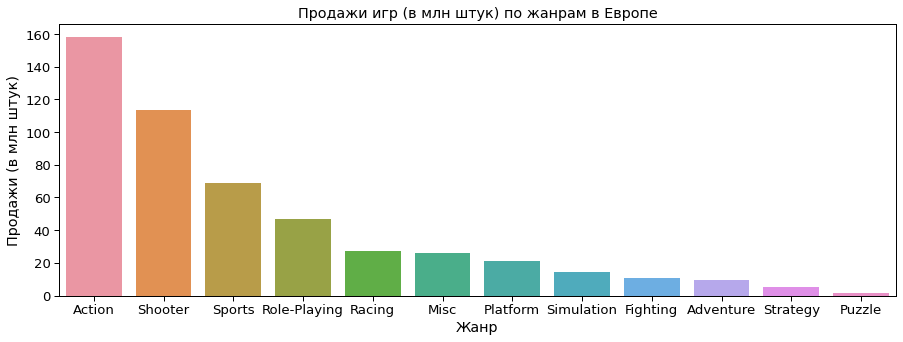

In [31]:
data_genre_eu = data_act.pivot_table(index='genre', values='eu_sales', aggfunc= ['sum', 'count', 'median', 'mean'])
data_genre_eu.columns = ['sum', 'count', 'median', 'mean']
data_genre_eu = data_genre_eu.sort_values(by='sum', ascending=False).reset_index()
print(data_genre_eu.sort_values(by='sum', ascending=False).head(5))

plt.figure(figsize=(15,5))
ax = sns.barplot(data=data_genre_eu, x='genre', y='sum')
plt.title("Продажи игр (в млн штук) по жанрам в Европе") 
ax.set_xlabel('Жанр')
ax.set_ylabel('Продажи (в млн штук)');
plt.show()

В Европе ситуация аналогична с Северной Америкой. Самые популярные жанры здесь такие же - Action, Shooter и Sports и Role-Playing.

          genre    sum  count  median      mean
0  Role-Playing  59.12    339    0.05  0.174395
1        Action  49.18    953    0.01  0.051605
2          Misc  12.45    180    0.02  0.069167
3    Simulation  10.35     78    0.00  0.132692
4       Shooter   9.23    235    0.00  0.039277


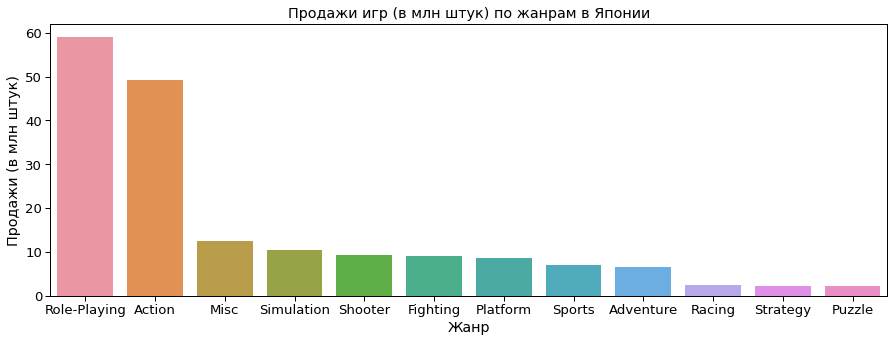

In [32]:
data_genre_jp = data_act.pivot_table(index='genre', values='jp_sales', aggfunc= ['sum', 'count', 'median', 'mean'])
data_genre_jp.columns = ['sum', 'count', 'median', 'mean']
data_genre_jp = data_genre_jp.sort_values(by='sum', ascending=False).reset_index()
print(data_genre_jp.sort_values(by='sum', ascending=False).head(5))

plt.figure(figsize=(15,5))
ax = sns.barplot(data=data_genre_jp, x='genre', y='sum')
plt.title("Продажи игр (в млн штук) по жанрам в Японии") 
ax.set_xlabel('Жанр')
ax.set_ylabel('Продажи (в млн штук)');
plt.show()

В Японии ситуация кардинально иная. С большим отрывом по суммарным продажам идут игры жанкров Role-Playing и Action.

  rating     sum  count  median      mean
0      M  231.57    498   0.155  0.465000
1      E  113.44    380   0.080  0.298526
2    TBD  100.13   1093   0.000  0.091610
3   E10+   75.09    301   0.130  0.249468
4      T   66.02    410   0.050  0.161024


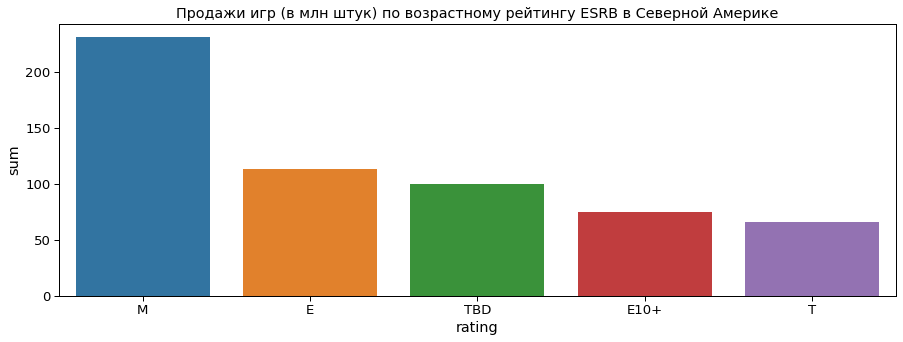

In [33]:
data_rating_na = data_act.pivot_table(index='rating', values='na_sales', aggfunc= ['sum', 'count', 'median', 'mean'])
data_rating_na.columns = ['sum', 'count', 'median', 'mean']
data_rating_na = data_rating_na.sort_values(by='sum', ascending=False).reset_index()
print(data_rating_na.sort_values(by='sum', ascending=False).head(5))

plt.figure(figsize=(15,5))
sns.barplot(data=data_rating_na, x='rating', y='sum')
plt.title("Продажи игр (в млн штук) по возрастному рейтингу ESRB в Северной Америке") 
ax.set_xlabel('Рейтинг')
ax.set_ylabel('Продажи (в млн штук)');
plt.show()

В Северной Америке больше всего продавались игры категории «M» («Для взрослых»): Материалы игры не подходят для подростков младше 17 лет.
На втором месте с несильным отставанием игры категории «E» («Everyone») — «Для всех».

  rating     sum  count  median      mean
0      M  193.96    498    0.13  0.389478
1      E  111.79    380    0.06  0.294184
2    TBD   89.32   1093    0.00  0.081720
3   E10+   54.84    301    0.11  0.182193
4      T   52.96    410    0.04  0.129171


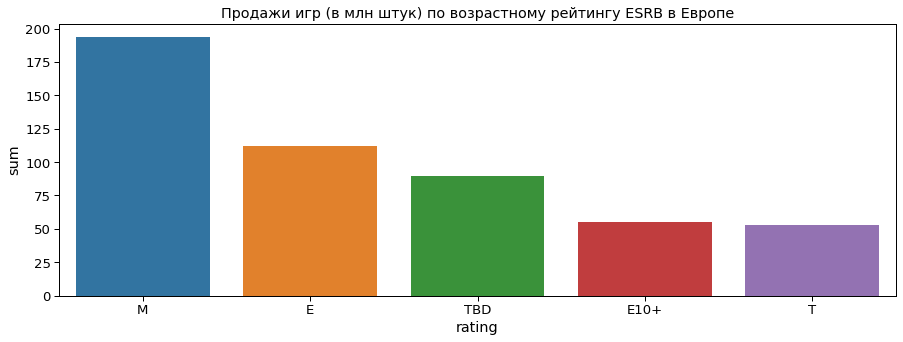

In [34]:
data_rating_eu = data_act.pivot_table(index='rating', values='eu_sales', aggfunc= ['sum', 'count', 'median', 'mean'])
data_rating_eu.columns = ['sum', 'count', 'median', 'mean']
data_rating_eu = data_rating_eu.sort_values(by='sum', ascending=False).reset_index()
print(data_rating_eu.sort_values(by='sum', ascending=False).head(5))

plt.figure(figsize=(15,5))
sns.barplot(data=data_rating_eu, x='rating', y='sum')
plt.title("Продажи игр (в млн штук) по возрастному рейтингу ESRB в Европе") 
ax.set_xlabel('Рейтинг')
ax.set_ylabel('Продажи (в млн штук)');
plt.show()

В Европе как и в Северной Америке больше всего продавались игры категории «M» («Для взрослых»): Материалы игры не подходят для подростков младше 17 лет.
На втором месте с несильным отставанием игры категории «E» («Everyone») — «Для всех».

  rating    sum  count  median      mean
0    TBD  95.62   1093    0.02  0.087484
1      E  27.62    380    0.00  0.072684
2      T  25.76    410    0.01  0.062829
3      M  21.20    498    0.00  0.042570
4   E10+   8.19    301    0.00  0.027209


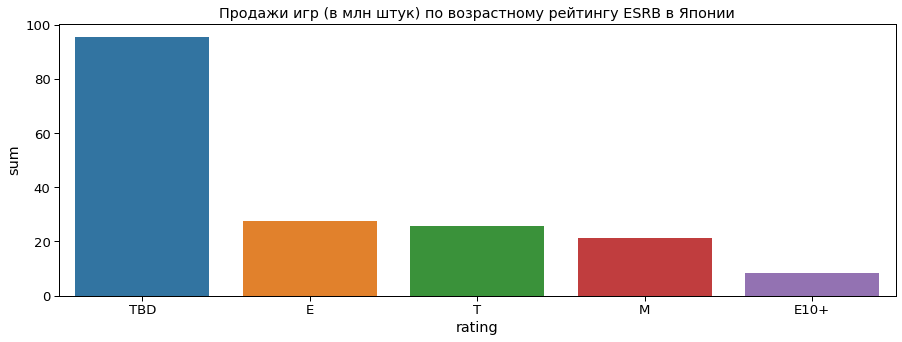

In [35]:
data_rating_jp = data_act.pivot_table(index='rating', values='jp_sales', aggfunc= ['sum', 'count', 'median', 'mean'])
data_rating_jp.columns = ['sum', 'count', 'median', 'mean']
data_rating_jp = data_rating_jp.sort_values(by='sum', ascending=False).reset_index()
print(data_rating_jp.sort_values(by='sum', ascending=False).head(5))

plt.figure(figsize=(15,5))
sns.barplot(data=data_rating_jp, x='rating', y='sum')
plt.title("Продажи игр (в млн штук) по возрастному рейтингу ESRB в Японии") 
ax.set_xlabel('Рейтинг')
ax.set_ylabel('Продажи (в млн штук)');
plt.show()

В Японии рейтинг информация рейтинга ESRB имеет меньшую значимость, так как ESRB - ассоциация прежде всего для оценки игр в Канаде и США.
Поэтому большинство игр, покупаемых в Японии не имею оценку по этому рейтингу ('TBD').

###  Общий вывод по четвёртому этапу исследования:
На данном этапе был составлен "потрет" пользователя каждого региона. В исследовании учитывалась информация за последние 5 лет среди платформ, по которым на момент 2016 издавались игры.

1. Северная Америка:
- Популярные платформы: X360, PS4, PS3. 
- Популярные жанры: action, shooter, sports.
- Продаваемые рейтинги: M, E
        
2. Европа:
- Популярные платформы: PS4, PS3, X360. 
- Популярные жанры: action, shooter, sports.
- Продаваемые рейтинги: M, E
3. Япония:
- Популярные платформы: 3DS, PS3, PSV. 
- Популярные жанры: Role-Playing, Action.

## Проверка гипотез

**Сформулируем гипотезы для первого исследования:**

- H0 - Средние пользовательские рейтинги платформ Xbox One и PC отличаются
- H1 - Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Уровень значимости 5% (alpha=.05)

In [37]:
sample_XOne = data_act[data_act['platform'] == 'XOne']['user_score'].dropna()
sample_PC = data_act[data_act['platform'] == 'PC']['user_score'].dropna()

Построим два распределения:

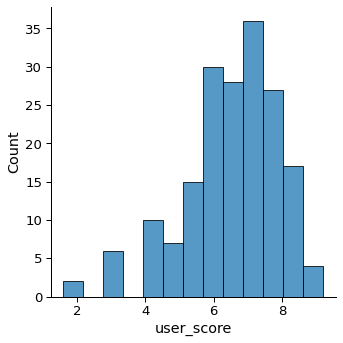

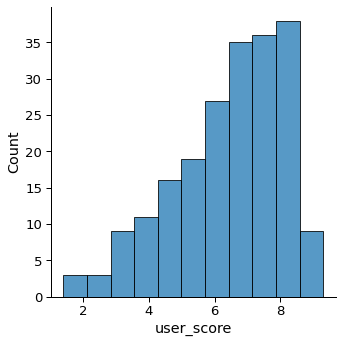

In [38]:
sns.displot(sample_XOne);
sns.displot(sample_PC);

**Проверка при помощи QQ-графиков:**

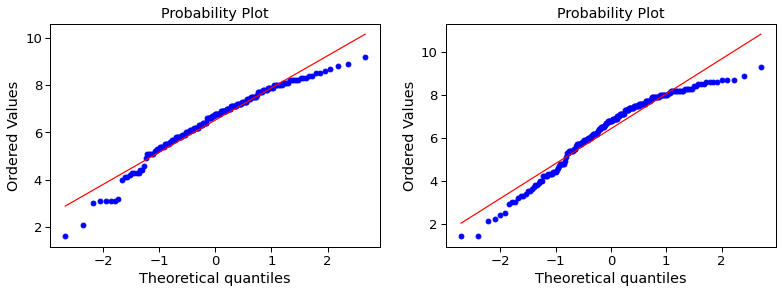

In [39]:
plt.figure(figsize=(13,9))
plt.subplot(2,2,1)
st.probplot(sample_XOne, dist='norm', plot=plt)
plt.subplot(2,2,2)
st.probplot(sample_PC, dist='norm', plot=plt)
plt.show()

Ориентируясь на построенные гистограммы и полученные графики, можно сделать вывод, что исходные данные не соответствуют нормальному распределению.

Таким образом воспользуемся методом ttest_ind, установив параметру equal_var значение False:

In [40]:
alpha = .05
results = st.ttest_ind(sample_XOne, sample_PC, equal_var = False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.5489537965134912
Не получилось отвергнуть нулевую гипотезу


p-значение 0.54, это значит, что нельзя отвергнуть нашу нулевую гипотезу, иными средние оценки пользователей XOne и PC статистически не отличаются.

**Сформулируем гипотезы для второго исследования:**

- H0 - Средние пользовательские рейтинги жанров Action и Sports одинаковые
- H1 - Средние пользовательские рейтинги жанров Action и Sports разные

Уровень значимости 5% (alpha=.05)

In [41]:
sample_action = data_act[data_act['genre'] == 'Action']['user_score'].dropna()
sample_sports = data_act[data_act['genre'] == 'Sports']['user_score'].dropna()

Построим два распределения:

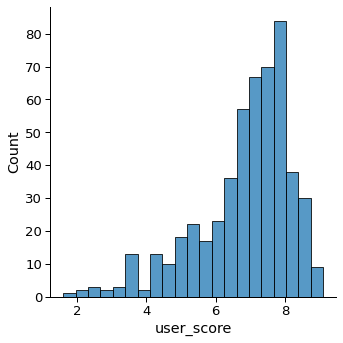

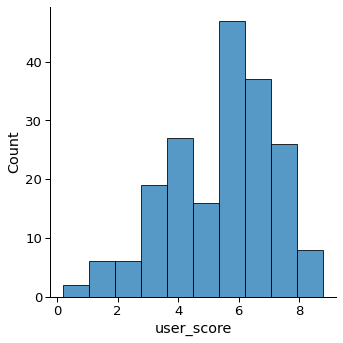

In [42]:
sns.displot(sample_action);
sns.displot(sample_sports);

**Проверка при помощи QQ-графиков:**

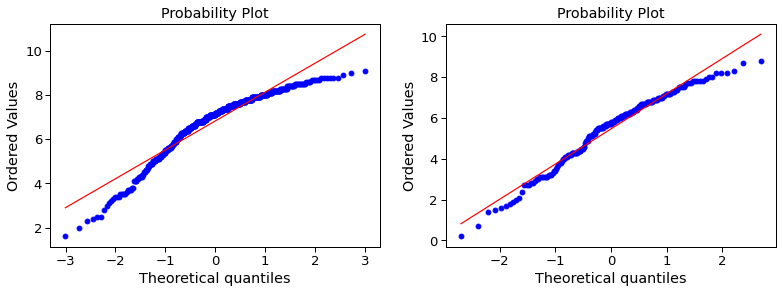

In [43]:
plt.figure(figsize=(13,9))
plt.subplot(2,2,1)
st.probplot(sample_action, dist='norm', plot=plt)
plt.subplot(2,2,2)
st.probplot(sample_sports, dist='norm', plot=plt)
plt.show()

Ориентируясь на построенные гистограммы и полученные графики, можно сделать вывод, что исходные данные не соответствуют нормальному распределению.

Таким образом воспользуемся методом ttest_ind, установив параметру equal_var значение False:

In [44]:
alpha = .05
results = st.ttest_ind(sample_action, sample_sports, equal_var = False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 5.1613574354387965e-20
Отвергаем нулевую гипотезу


p-значение - 5.16e-20, отвергается нулевая гипотеза, а это значит что оценки пользователей жанров "Action" и "Sports" статистически различаются.

  platform      mean
0      PSV  7.410000
1      3DS  7.033333
2     WiiU  6.904000
3      PS4  6.748249
4      PS3  6.532862


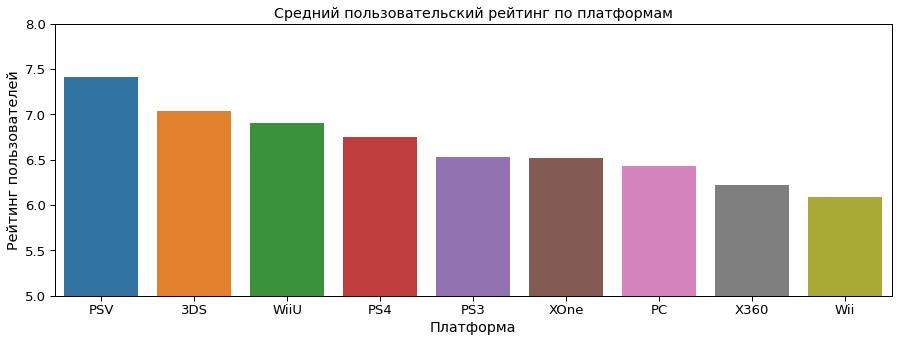

In [45]:
data_mean_platf = data_act.pivot_table(index='platform', values='user_score', aggfunc= ['mean'])
data_mean_platf.columns = ['mean']
data_mean_platf = data_mean_platf.sort_values(by='mean', ascending=False).reset_index()
print(data_mean_platf.sort_values(by='mean', ascending=False).head(5))

plt.figure(figsize=(15,5))
ax = sns.barplot(data=data_mean_platf, x='platform', y='mean')
plt.title("Средний пользовательский рейтинг по платформам") 
ax.set_xlabel('Платформа')
ax.set_ylim(5, 8);
ax.set_ylabel('Рейтинг пользователей');
plt.show()

          genre      mean
0        Puzzle  7.633333
1     Adventure  7.466667
2  Role-Playing  7.236905
3          Misc  6.938806
4      Fighting  6.895714


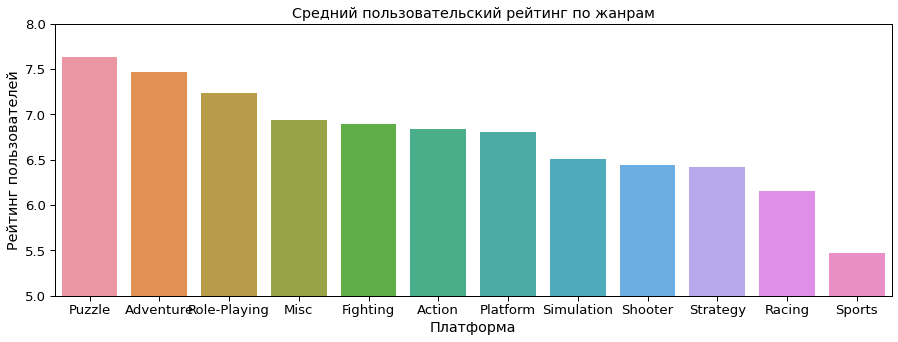

In [46]:
data_mean_genre = data_act.pivot_table(index='genre', values='user_score', aggfunc= ['mean'])
data_mean_genre.columns = ['mean']
data_mean_genre = data_mean_genre.sort_values(by='mean', ascending=False).reset_index()
print(data_mean_genre.sort_values(by='mean', ascending=False).head(5))

plt.figure(figsize=(15,5))
ax = sns.barplot(data=data_mean_genre, x='genre', y='mean')
plt.title("Средний пользовательский рейтинг по жанрам") 
ax.set_xlabel('Платформа')
ax.set_ylim(5, 8);
ax.set_ylabel('Рейтинг пользователей');
plt.show()

Выше проиллюстрированы различия в средних оценках пользователей в разрезах по платформам и жанрам. 

Например, можно увидеть даже "невооружённым" статистическими инструментами глазом, что средняя оценка жанра Sports отличается.

###  Общий вывод по пятому этапу исследования:

- Средние оценки пользователей платформ 'PC' И 'XOne' статистически не отличаются. Это значит, что можно говорить о том, что средние оценки пользователей этих двух платформ одинаковые.
- Оценки пользователей жанров 'Action' и 'Sport' статистически различаются. Нельзя говорить о том, что средние оценки двух этих жанров одинаковые.

## Общий вывод

**В ходе исследования была проведена следующая работа:**
- Подготовлены данные по играм (удалены/заменены по возможности пропуски, изменены типы данных на более корректные);
- Определён для целей исследования актуальный период, который подразумевает данные по платформам, на которые на момент 2016 года выходят игры, а также данные по играм не ранее 2012 года;
- Построен ряд графиков, визуально характеризующие представленные выводы;
- Проведено статистическое исследование на проверку двух гипотез;

**В ходе исследования была получены следующие результаты:**
- На протяжении последних 20 лет игровой рынок пережил две стадии (быстрого роста до 2008 года), падение по текущий момент. Сейчас показатели продаж идентичны показателям начала нулевых. Возможно, причина кроется в интенсивном развитии рынка мобильных игр;
- Средняя продолжительность жизни платформы примерно 9 лет. Исключение - персональные компьютеры;


- На текущий момент (2016 год) наиболее перспективными для игр выглядят следующие платформы PC, PSV, XOne, PS4. Первые две за счёт объёма продаж - а XOne и PS4 за счёт "новизны" и активного роста. При этом PS4 на 2016 год  уже является самой популярной платформой.
- Подавляющее большинство игр продаются объёмам не более 2 млн копий. При этом обнаружилась корреляция слабой силы между оценками экспертов и количеством проданных копий игр. Заметная связь между продажами и оценками пользователей не обнаружена.
- Больше всего продаётся игр жанров Action, Shooter и Sports. Однако самым "прибыльным" является жанр Shooter.


- Средний портрет пользователя в регионах отличается. При этом Северная Америка и Европа отличаются между собой несильно. Предпочтения по играм/платформам в Японии более уникальны.
- В Северной Америке самая популярная платформа - X360, Европа - PS4, Япония - 3DS.
- В Европе и Северной Америке самые популярные жанры - action, shooter, sports. В Японии - Role-Playing, Action.

- Можно сказать, что средние оценки пользователей 'PC' И 'XOne' одинаковые. При этом нельзя утверждать, что средние оценки 'Action' и 'Sport'-игр одинаковые.

**Практические рекомендации:**
- Прежде всего нужно рекламировать игры платформ PS4 и XOne - как новые и только набирающие свою популярность платформ. Они должны вытеснить своих прешественников PS3 и X360. При этом игры на XOne стоит рассматривать на американском направлении, а PS4 - приоритет на европейском.
- Японское направление выглядит менее приоритетным за счёт меньшего объёма рынка и своей специфики - популярные платформы и жанры существенно отличаются от европейских и американских.


- Жанр Action - самый популярный, но это обеспечивается засчёт аномальных продаж некоторых игр, а для большинства игр объём продаж этих игр весьма скромный.
- Поэтому по жанрам стоит ориентироваться не те, которые дают наибольший объём продаж на одну игру. Как правило, это Shooter и Sports. Жанр Role-Playing тоже обладает неплохим потенциалом.

- Возрастные рейтинги игр желательно должны быть M или E -  они демонстрируют наибольшие продажи.